Copyright (c) Nongnuch Artrith (nartrith@atomistic.net) and Alexander Urban

This Source Code Form is subject to the terms of the Mozilla Public License, v. 2.0. If a copy of the MPL was not distributed with this file, You can obtain one at http://mozilla.org/MPL/2.0/.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the Mozilla Public License, v. 2.0, for more details.

In [1]:
import itertools
import functools
import os
import sys

import pandas as pd
import numpy as np

from scipy.optimize import least_squares

from pymatgen.analysis.reaction_calculator import Reaction
from pymatgen import Composition

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import howru
from howru.compound import read_compounds_from_csv, read_elements_from_csv
from howru.reactions import Reactions
from howru.optimize import UOptimizer

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
rcparams = {"font.size": 14,
            "legend.frameon": False,
            "xtick.top": True,
            "xtick.direction": "in",
            "xtick.minor.visible": True,
            "xtick.major.size": 8,
            "xtick.minor.size": 4,
            "ytick.right": True,
            "ytick.direction": "in",
            "ytick.minor.visible": True,
            "ytick.major.size": 8,
            "ytick.minor.size": 4}
plt.rcParams.update(rcparams)

In [2]:
elements = "elements-SCAN+rvv10-energies.csv"
binaries = "binary-oxides-SCAN+rvv10-energies.csv"
ternaries = "ternary-oxides-SCAN+rvv10-energies.csv"
TM_species = ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']

# U Optimizer

In [3]:
opt = UOptimizer(TM_species, elements, binaries, ternaries)

Optimization problem
$$
U_{\mathrm{opt}} = \arg \min{}_U \sqrt{||\vec{e}(U)||}
$$
with
$$
  \vec{e}(U) = \mathbf{R} \cdot \vec{E}_{\mathrm{comp}}(U) - \Delta \vec{E}_{\mathrm{expt}}
$$
where $\mathbf{R}$ is a matrix containing the reactions, $\vec{E}_{\mathrm{comp}}(U, J)$ is a vector with the DFT energies of each compound for a given set of U values $U$, and $\Delta \vec{E}_{\mathrm{expt}}$ is a vector containing the experimental reference values of the reaction energies.

Row $i$ of matrix $\mathbf{R}$ contains the coefficients of the $i$-th chemical reaction
$$
\vec{R}_{i} = \left( c_1^{i}, c_2^{i}, \ldots, c_N^{i} \right)
$$
where negative coefficients belong to reactants and positive coefficients belong to products.  The predicted reaction energy $\Delta E_comp^i$ of the $i$-th reaction is given by
$$
  \Delta E_comp^i = \vec{R}_{i} \cdot \vec{E}_{\mathrm{comp}}(U) .
$$

In [4]:
# root mean square error without U or Jain
R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
U = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
E_comp = opt.compound_energies(U)
err = R.dot(E_comp) - dE_exp
print("rmse (no +U) = {:.6f} eV".format(np.sqrt(np.mean(err**2))))

rmse (no +U) = 0.415175 eV


### Optimize U values

In [5]:
def objective(U, l2):
    R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
    E_comp = opt.compound_energies(U, Jain='auto')
    # err = (R.dot(E_comp) - dE_exp)/num_atoms
    err = (R.dot(E_comp) - dE_exp)
    return np.sqrt(np.mean(err**2)) + l2*np.linalg.norm(U)

U = [0.00, 2.16, 0.95, 2.52, 2.29, 0.55, 2.13, 0.47, 0.00, 0.00]

df = pd.DataFrame(columns=['l2', 'rmse', 'U', 'J'])
for l2 in [0.000, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030, 0.035, 0.040, 0.045, 0.050]:
    f = functools.partial(objective, l2=l2)
    results = least_squares(f, U, bounds=(0.0, 5.0), ftol=1.0e-4, xtol=1.0e-3)
    U = results.x
    R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
    E_comp = opt.compound_energies(U, Jain='auto')
    err = R.dot(E_comp) - dE_exp
    rmse = np.sqrt(np.mean(err**2))
    J = list(opt.metal_corrections.values())
    df = df.append({'l2': l2, 'rmse': rmse, 'U': U.tolist(), 'J': J}, ignore_index=True)
    print("done with l2 = {}".format(l2))

df.to_csv('l2-regularization.csv', index=False)

done with l2 = 0.0
done with l2 = 0.005
done with l2 = 0.01
done with l2 = 0.015
done with l2 = 0.02
done with l2 = 0.025
done with l2 = 0.03
done with l2 = 0.035
done with l2 = 0.04
done with l2 = 0.045
done with l2 = 0.05


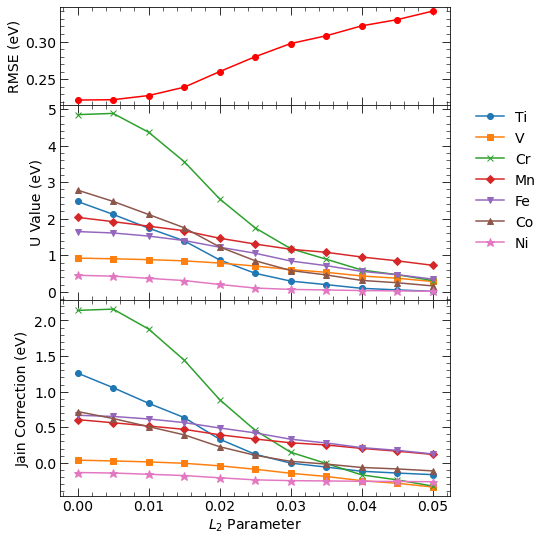

In [6]:
def float_list(string):
    return [float(a) for a in string[1:-1].split(',')]

def plot_l2(df):
    data = np.array([[df['l2'].values[i], df['rmse'].values[i]] 
                     + float_list(df['U'].values[i])
                     + float_list(df['J'].values[i]) for i in range(len(df.index))])
    fig, ax = plt.subplots(3, 1, figsize=(7, 9), sharex=True, sharey=False,
                           gridspec_kw={'height_ratios': [1, 2, 2], 'hspace': 0, 'wspace': 0.3},)
    ax[0].set_ylabel("RMSE (eV)")
    ax[0].plot(data[:, 0], data[:, 1], label='rmse', color='red', marker='o')
    ax[1].set_ylabel("U Value (eV)")
    ax[1].plot(data[:, 0], data[:, 3], label='Ti', marker='o')
    ax[1].plot(data[:, 0], data[:, 4], label='V',  marker='s')
    ax[1].plot(data[:, 0], data[:, 5], label='Cr', marker='x')
    ax[1].plot(data[:, 0], data[:, 6], label='Mn', marker='D')
    ax[1].plot(data[:, 0], data[:, 7], label='Fe', marker='v')
    ax[1].plot(data[:, 0], data[:, 8], label='Co', marker='^')
    ax[1].plot(data[:, 0], data[:, 9], label='Ni', marker='*', markersize=9)
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[2].set_ylabel("Jain Correction (eV)")
    ax[2].set_xlabel("$L_2$ Parameter")
    ax[2].plot(data[:, 0], data[:, 13], label='Ti', marker='o')
    ax[2].plot(data[:, 0], data[:, 14], label='V',  marker='s')
    ax[2].plot(data[:, 0], data[:, 15], label='Cr', marker='x')
    ax[2].plot(data[:, 0], data[:, 16], label='Mn', marker='D')
    ax[2].plot(data[:, 0], data[:, 17], label='Fe', marker='v')
    ax[2].plot(data[:, 0], data[:, 18], label='Co', marker='^')
    ax[2].plot(data[:, 0], data[:, 19], label='Ni', marker='*', markersize=9)
    plt.savefig("./figures/graph-l2-regularization.pdf", bbox_inches='tight')
    
df = pd.read_csv('l2-regularization.csv')
plot_l2(df)

In [7]:
# redo optimization for one specific l2 parameter
l2 = 0.01

U = [0.00, 2.16, 0.95, 2.52, 2.29, 0.55, 2.13, 0.47, 0.00, 0.00]
f = functools.partial(objective, l2=l2)
results = least_squares(f, U, bounds=(0.0, 5.0), ftol=1.0e-4, xtol=1.0e-3)
U_opt = results.x
R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
E_comp = opt.compound_energies(U_opt, Jain='auto')
err = R.dot(E_comp) - dE_exp
rmse = np.sqrt(np.mean(err**2))
print('rmse = {} eV'.format(rmse))
print('        ', (10*' {:5s}').format(*opt.metal_corrections.keys()))
print('U_opt = ', (10*'{:5.2f} ').format(*U_opt))
print('J_opt = ', (10*'{:5.2f} ').format(*opt.metal_corrections.values()))

rmse = 0.23118452682428559 eV
          Sc    Ti    V     Cr    Mn    Fe    Co    Ni    Cu    Zn   
U_opt =   0.00  1.68  0.88  4.10  1.77  1.50  2.05  0.37  0.00  0.00 
J_opt =   0.00  0.80  0.01  1.74  0.51  0.61  0.49 -0.16  0.02  0.00 


In [8]:
# repeat optimization but with the implemented loss function
U = [0.00, 2.16, 0.95, 2.52, 2.29, 0.55, 2.13, 0.47, 0.00, 0.00]
J = opt.metal_corrections.copy()
U_val_max = [5.0 for u in U]
U_opt = opt.optimize_U(U, U_val_max, metal_corrections=J,
                       metal_corrections_fit=True,
                       print_iterations=False, l2reg=0.01,
                       opt_binary_oxide_reactions=True,
                       opt_ternary_oxide_reactions=True,
                       opt_binary_o2_reactions=True,
                       opt_ternary_o2_reactions=True,
                       opt_binary_oxide_formations=True,
                       opt_ternary_oxide_formations=True)

R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
E_comp = opt.compound_energies(U_opt, Jain=list(opt.metal_corrections.values()))
rmse = np.sqrt(np.mean(err**2))
print('rmse = {} eV'.format(rmse))
print('        ', (10*' {:5s}').format(*opt.metal_corrections.keys()))
print('U_opt = ', (10*'{:5.2f} ').format(*U_opt))
print('J_opt = ', (10*'{:5.2f} ').format(*opt.metal_corrections.values()))

rmse = 0.23118452682428559 eV
          Sc    Ti    V     Cr    Mn    Fe    Co    Ni    Cu    Zn   
U_opt =   0.00  1.68  0.88  4.10  1.77  1.50  2.05  0.37  0.00  0.00 
J_opt =   0.00  0.80  0.01  1.74  0.51  0.61  0.49 -0.16  0.02  0.00 


### Now repeat optimization but weight reactions by their similarity with other reactions.

In [9]:
n_components = 57

R, dE_exp, reactions, num_atoms = opt.reaction_matrix()

# reduce dimension with PCA
pca = PCA(n_components=n_components)
components = pca.fit_transform(R)
print("explained variance: ", pca.explained_variance_ratio_)
print("explained variance (cumulative): ", np.cumsum(pca.explained_variance_ratio_))
print("total explained variance", np.sum(pca.explained_variance_ratio_))

explained variance:  [3.14376459e-01 1.24964480e-01 9.21161041e-02 6.75963040e-02
 5.31976407e-02 3.87236942e-02 2.80129299e-02 2.35417839e-02
 2.16649550e-02 1.90336812e-02 1.63460131e-02 1.54943034e-02
 1.44778176e-02 1.43643840e-02 1.30603085e-02 1.22889209e-02
 1.16927611e-02 1.12474836e-02 1.05848569e-02 1.03909303e-02
 9.18080031e-03 8.27463505e-03 7.37978117e-03 7.17060225e-03
 6.64802504e-03 6.15279183e-03 5.82967508e-03 5.06959996e-03
 4.72470728e-03 3.95404733e-03 3.69600612e-03 3.57696651e-03
 3.09615180e-03 2.99697209e-03 2.79739825e-03 2.22114666e-03
 1.96636044e-03 1.14283052e-03 9.45690948e-04 2.04210614e-31
 7.83676781e-32 5.77477268e-32 4.92400386e-32 3.63299871e-32
 3.38882590e-32 2.51420788e-32 1.68435205e-32 1.34244429e-32
 5.23503181e-33 1.10293168e-33 1.10293168e-33 1.10293168e-33
 1.10293168e-33 1.10293168e-33 1.10293168e-33 1.10293168e-33
 4.55731374e-35]
explained variance (cumulative):  [0.31437646 0.43934094 0.53145704 0.59905335 0.65225099 0.69097468
 0.7189

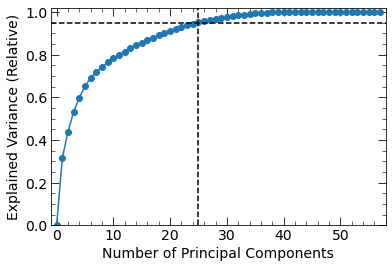

In [10]:
def plot_pca_explained_variance(explained_variance_ratio):
    explained_variance = np.cumsum([0] + explained_variance_ratio.tolist())
    df = pd.DataFrame({'Explained Variance': explained_variance})
    fig, ax = plt.subplots()
    ax.set_xlabel("Number of Principal Components")
    ax.set_ylabel("Explained Variance (Relative)")
    ax.set_ylim([0, 1.02])
    ax.set_xlim([-1, len(explained_variance)])
    df.plot(ax=ax, marker='o', legend=False)
    ax.plot([plt.xlim()[0], plt.xlim()[1]], [0.95, 0.95], ls='--', color='black')
    ax.plot([25, 25], [plt.ylim()[0], plt.ylim()[1]], ls='--', color='black')
    plt.savefig("./figures/graph-pca-variance.pdf", bbox_inches='tight')
    
plot_pca_explained_variance(pca.explained_variance_ratio_)

In [11]:
n_components = 25

# redo PCA with selected number of PCs
pca = PCA(n_components=n_components)
components = pca.fit_transform(R)

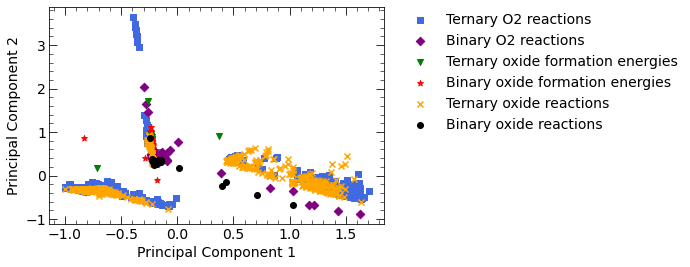

In [12]:
# visualization of the PCA
def plot_pca(opt, pca):
    fig, ax = plt.subplots()
    marker = itertools.cycle((',', 'D', 'v', '*', 'x', 'o')) 
    color = itertools.cycle(('royalblue', 'purple', 'green', 'red', 'orange', 'black')) 
    for kind in reversed(opt.reactions):
        data = pca.transform(opt.reactions[kind].reaction_matrix)
        ax.scatter(data[:, 0], data[:, 1], marker=next(marker), color=next(color), label=kind)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    plt.savefig("./figures/graph-pca-clusters.pdf", bbox_inches='tight')

plot_pca(opt, pca)

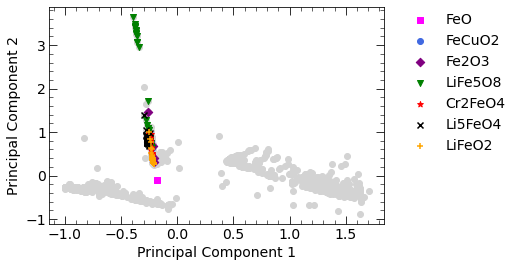

In [13]:
# Fe compounds as one example
def plot_pca(reactions, components):
    fig, ax = plt.subplots()
    marker = itertools.cycle((',', 'o', 'D', 'v', '*', 'x', '+')) 
    color = itertools.cycle(('magenta', 'royalblue', 'purple', 'green', 'red', 'black', 'orange')) 
    data = components
    ax.scatter(data[:, 0], data[:, 1], marker='o', color='lightgrey')
    for comp in ['FeO', 'FeCuO2', 'Fe2O3', 'LiFe5O8', 'Cr2FeO4', 'Li5FeO4', 'LiFeO2']:
        idx = np.array([Composition(comp) in r.products for r in reactions])
        data = components[idx]
        ax.scatter(data[:, 0], data[:, 1], marker=next(marker), color=next(color), label=comp)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    plt.savefig("./figures/graph-pca-clusters-Fe.pdf", bbox_inches='tight')

plot_pca(reactions, components)

### Group reactions using k-means clustering

In [14]:
def objective2(U, l2, weight):
    R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
    E_comp = opt.compound_energies(U, Jain='auto')
    err = (R.dot(E_comp) - dE_exp)*weight
    # the error needs to be rescaled so that the same 
    # regularization parameter can be used
    a = len(weight)/np.sum(weight)
    return np.sqrt(np.mean(err**2))*a + l2*np.linalg.norm(U)

l2 = 0.01
U = [0.00, 2.16, 0.95, 2.52, 2.29, 0.55, 2.13, 0.47, 0.00, 0.00]

df = pd.DataFrame(columns=['ncl', 'rmse', 'U', 'J'])
for ncl in [37, 74, 111, 148, 222, 444, 666, 888, 1110, 1332, 1554, 1700]:

    # k-means clustering of the reactions to determine similarities
    kmeans = KMeans(n_clusters=ncl).fit(components)
    labels = kmeans.labels_
    
    # calculate the weight of the reactions based on the frequency of their label
    unique_labels = set(labels)
    counts = {l: labels.tolist().count(l) for l in unique_labels}
    label_weight = [1.0/counts[l] for l in labels]
    
    # optimize U values
    f = functools.partial(objective2, l2=l2, weight=label_weight)
    results = least_squares(f, U, bounds=(0.0, 5.0), ftol=1.0e-4, xtol=1.0e-3)
    
    # compile results
    U_opt = results.x
    R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
    E_comp = opt.compound_energies(U_opt, Jain='auto')
    err = R.dot(E_comp) - dE_exp
    rmse = np.sqrt(np.mean(err**2))
    J = list(opt.metal_corrections.values())
    
    df = df.append({'ncl': ncl, 'rmse': rmse, 
                    'U': U_opt.tolist(), 
                    'J': J}, ignore_index=True)
    
    print("done with ncl = {}".format(ncl))
    
df.to_csv('kmeans.csv')

done with ncl = 37
done with ncl = 74
done with ncl = 111
done with ncl = 148
done with ncl = 222
done with ncl = 444
done with ncl = 666
done with ncl = 888
done with ncl = 1110
done with ncl = 1332
done with ncl = 1554
done with ncl = 1700


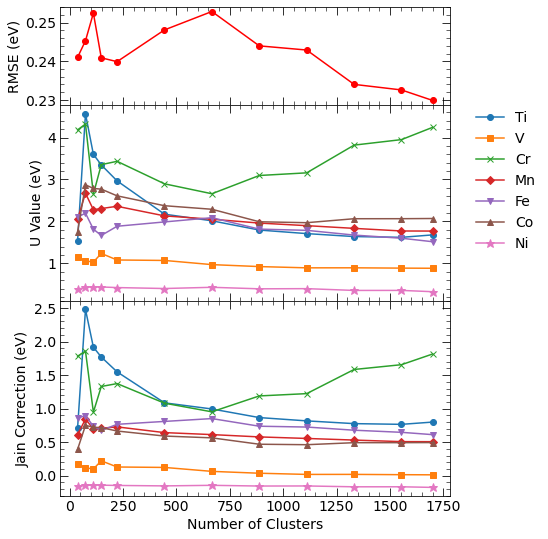

In [15]:
def float_list(string):
    return [float(a) for a in string[1:-1].split(',')]

def plot_kmeans(df):
    data = np.array([[df['ncl'].values[i], df['rmse'].values[i]] 
                     + float_list(df['U'].values[i])
                     + float_list(df['J'].values[i]) for i in range(len(df.index))])
    fig, ax = plt.subplots(3, 1, figsize=(7, 9), sharex=True, sharey=False,
                           gridspec_kw={'height_ratios': [1, 2, 2], 'hspace': 0, 'wspace': 0.3},)
    ax[0].set_ylabel("RMSE (eV)")
    ax[0].plot(data[:, 0], data[:, 1], label='rmse', color='red', marker='o')
    ax[1].set_ylabel("U Value (eV)")
    ax[1].plot(data[:, 0], data[:, 3], label='Ti', marker='o')
    ax[1].plot(data[:, 0], data[:, 4], label='V',  marker='s')
    ax[1].plot(data[:, 0], data[:, 5], label='Cr', marker='x')
    ax[1].plot(data[:, 0], data[:, 6], label='Mn', marker='D')
    ax[1].plot(data[:, 0], data[:, 7], label='Fe', marker='v')
    ax[1].plot(data[:, 0], data[:, 8], label='Co', marker='^')
    ax[1].plot(data[:, 0], data[:, 9], label='Ni', marker='*', markersize=9)
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[2].set_ylabel("Jain Correction (eV)")
    ax[2].set_xlabel("Number of Clusters")
    ax[2].plot(data[:, 0], data[:, 13], label='Ti', marker='o')
    ax[2].plot(data[:, 0], data[:, 14], label='V',  marker='s')
    ax[2].plot(data[:, 0], data[:, 15], label='Cr', marker='x')
    ax[2].plot(data[:, 0], data[:, 16], label='Mn', marker='D')
    ax[2].plot(data[:, 0], data[:, 17], label='Fe', marker='v')
    ax[2].plot(data[:, 0], data[:, 18], label='Co', marker='^')
    ax[2].plot(data[:, 0], data[:, 19], label='Ni', marker='*', markersize=9)
    plt.savefig("./figures/graph-kmeans-clustering.pdf", bbox_inches='tight')
    
df = pd.read_csv('kmeans.csv')
plot_kmeans(df)

In [16]:
# repeat k-means clustering with one specific number of clusters
n_clusters = 888

# k-means clustering of the reactions to determine similarities
kmeans = KMeans(n_clusters=n_clusters).fit(components)
labels = kmeans.labels_

# calculate the weight of the reactions based on the frequency of their label
unique_labels = set(labels)
counts = {l: labels.tolist().count(l) for l in unique_labels}
label_weight = [1.0/counts[l] for l in labels]

# count TM occurrence with and without weights
R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
counts = {}
wcounts = {}
for TM in opt.TM_species:
    match = np.where([TM in str(r) for r in reactions], 1, 0)
    counts[TM] = np.sum(match)
    wcounts[TM] = np.sum(match*label_weight)

### Optimize U values for chosen number of PCs and clusters

In [17]:
opt = UOptimizer(TM_species, elements, binaries, ternaries)

n_clusters = 888
# n_clusters = 250
n_components = 25
U = [0.001, 1.83, 0.93, 2.77, 1.97, 1.83, 2.10, 0.43, 0.001, 0.001]

R, dE_exp, reactions, num_atoms = opt.reaction_matrix()

# PCA with selected number of PCs
pca = PCA(n_components=n_components)
components = pca.fit_transform(R)
    
# k-means clustering of the reactions to determine similarities
kmeans = KMeans(n_clusters=n_clusters).fit(components)
labels = kmeans.labels_

# calculate the weight of the reactions based on the frequency of their label
unique_labels = set(labels)
counts = {l: labels.tolist().count(l) for l in unique_labels}
label_weight = [1.0/counts[l] for l in labels]

def objective2(U, l2, R, dE_exp, weight, Jain):
    E_comp = opt.compound_energies(U, Jain=Jain)
    err = (R.dot(E_comp) - dE_exp)*weight
    a = len(weight)/np.sum(weight)
    return np.sqrt(np.mean(err**2))*a + l2*np.linalg.norm(U)

#---------------------------------------
label = '1. no L2 + no Jain'
#---------------------------------------

l2 = 0.00
Jain = None
U = [0.001, 1.83, 0.93, 2.77, 1.97, 1.83, 2.10, 0.43, 0.001, 0.001]

# optimize U values
f = functools.partial(objective2, l2=l2, R=R, 
                      dE_exp=dE_exp, weight=label_weight,
                      Jain=Jain)
results = least_squares(f, U, bounds=(0.0, 5.0), ftol=1.0e-4, xtol=1.0e-3)

# compile results
U_opt = results.x
R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
E_comp = opt.compound_energies(U_opt, Jain=Jain)
err = R.dot(E_comp) - dE_exp
rmse = np.sqrt(np.mean(err**2))
weighted_rmse = np.sqrt(np.sum((err*label_weight)**2)/np.sum(label_weight))

print('\n----------\n{}\n'.format(label))
print('rmse = {} eV'.format(rmse))
print('weighted rmse = {} eV'.format(weighted_rmse))
print('        ', (10*' {:5s}').format(*opt.TM_species))
print('U_opt = ', (10*'{:5.2f} ').format(*U_opt))

#---------------------------------------
label = '2. L2 + no Jain'
#---------------------------------------

l2 = 0.01
Jain = None
U = [0.001, 1.83, 0.93, 2.77, 1.97, 1.83, 2.10, 0.43, 0.001, 0.001]

# optimize U values
f = functools.partial(objective2, l2=l2, R=R, 
                      dE_exp=dE_exp, weight=label_weight,
                      Jain=Jain)
results = least_squares(f, U, bounds=(0.0, 5.0), ftol=1.0e-4, xtol=1.0e-3)

# compile results
U_opt = results.x
R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
E_comp = opt.compound_energies(U_opt, Jain=Jain)
err = R.dot(E_comp) - dE_exp
rmse = np.sqrt(np.mean(err**2))
weighted_rmse = np.sqrt(np.sum((err*label_weight)**2)/np.sum(label_weight))

print('\n----------\n{}\n'.format(label))
print('rmse = {} eV'.format(rmse))
print('weighted rmse = {} eV'.format(weighted_rmse))
print('        ', (10*' {:5s}').format(*opt.TM_species))
print('U_opt = ', (10*'{:5.2f} ').format(*U_opt))

#---------------------------------------
label = '3. no L2 + Jain'
#---------------------------------------

l2 = 0.00
Jain = 'auto'
U = [0.001, 1.83, 0.93, 2.77, 1.97, 1.83, 2.10, 0.43, 0.001, 0.001]

# optimize U values
f = functools.partial(objective2, l2=l2, R=R, 
                      dE_exp=dE_exp, weight=label_weight,
                      Jain=Jain)
results = least_squares(f, U, bounds=(0.0, 8.0), ftol=1.0e-4, xtol=1.0e-3)

# compile results
U_opt = results.x
R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
E_comp = opt.compound_energies(U_opt, Jain='auto')
err = R.dot(E_comp) - dE_exp
rmse = np.sqrt(np.mean(err**2))
weighted_rmse = np.sqrt(np.sum((err*label_weight)**2)/np.sum(label_weight))
J = list(opt.metal_corrections.values())

print('\n----------\n{}\n'.format(label))
print('rmse = {} eV'.format(rmse))
print('weighted rmse = {} eV'.format(weighted_rmse))
print('        ', (10*' {:5s}').format(*opt.metal_corrections.keys()))
print('U_opt = ', (10*'{:5.2f} ').format(*U_opt))
print('J_opt = ', (10*'{:5.2f} ').format(*J))

#---------------------------------------
label = '4. L2 + Jain'
#---------------------------------------

l2 = 0.01
Jain = 'auto'
U = [0.001, 1.83, 0.93, 2.77, 1.97, 1.83, 2.10, 0.43, 0.001, 0.001]

# optimize U values
f = functools.partial(objective2, l2=l2, R=R, 
                      dE_exp=dE_exp, weight=label_weight,
                      Jain=Jain)
results = least_squares(f, U, bounds=(0.0, 5.0), ftol=1.0e-4, xtol=1.0e-3)

# compile results
U_opt = results.x
R, dE_exp, reactions, num_atoms = opt.reaction_matrix()
E_comp = opt.compound_energies(U_opt, Jain='auto')
err = R.dot(E_comp) - dE_exp
rmse = np.sqrt(np.mean(err**2))
weighted_rmse = np.sqrt(np.sum((err*label_weight)**2)/np.sum(label_weight))
J = list(opt.metal_corrections.values())

print('\n----------\n{}\n'.format(label))
print('rmse = {} eV'.format(rmse))
print('weighted rmse = {} eV'.format(weighted_rmse))
print('        ', (10*' {:5s}').format(*opt.metal_corrections.keys()))
print('U_opt = ', (10*'{:5.2f} ').format(*U_opt))
print('J_opt = ', (10*'{:5.2f} ').format(*J))


----------
1. no L2 + no Jain

rmse = 0.298602915575479 eV
weighted rmse = 0.308763795031554 eV
          Sc    Ti    V     Cr    Mn    Fe    Co    Ni    Cu    Zn   
U_opt =   0.00  0.60  0.96  1.11  1.48  0.95  1.54  0.53  0.00  0.00 

----------
2. L2 + no Jain

rmse = 0.3004885915935852 eV
weighted rmse = 0.30961315612832657 eV
          Sc    Ti    V     Cr    Mn    Fe    Co    Ni    Cu    Zn   
U_opt =   0.00  0.53  0.92  1.04  1.40  0.89  1.23  0.38  0.00  0.00 

----------
3. no L2 + Jain

rmse = 0.22203779039772156 eV
weighted rmse = 0.2386240383715962 eV
          Sc    Ti    V     Cr    Mn    Fe    Co    Ni    Cu    Zn   
U_opt =   0.00  2.49  0.95  5.52  2.19  1.97  2.86  0.42  0.00  0.00 
J_opt =   0.00  1.27  0.05  2.51  0.66  0.80  0.75 -0.15  0.02  0.00 

----------
4. L2 + Jain

rmse = 0.24427267711532977 eV
weighted rmse = 0.2483426765524631 eV
          Sc    Ti    V     Cr    Mn    Fe    Co    Ni    Cu    Zn   
U_opt =   0.00  1.83  0.93  3.06  1.97  1.84  2.05  0.3

In [19]:
R, dE_exp, reactions, num_atoms = opt.reaction_matrix()

pd.set_option('display.max_colwidth', None)
data = {
    'Label': labels,
    'Weight': label_weight,
    'ΔrH0 (eV/atom)': dE_exp,
    'Reaction': reactions
}
df = pd.DataFrame(data).sort_values('Label', ignore_index=True)
df.to_csv('all_reactions.csv', index=False)
df.head()

,Label,Weight,ΔrH0 (eV/atom),Reaction
0,0,1.0,-3.438775,V2O3 + O2 -> V2O5
1,1,0.5,-0.891835,0.1 Mn2O3 + 0.1 Mn3O4 + 0.4 MnO + 0.1 MnO2 + 0.3 Ti3O5 + 0.1 TiO2 -> TiMnO3
2,1,0.5,-0.956576,0.1111 Mn2O3 + 0.1111 Mn3O4 + 0.3333 MnO + 0.1111 MnO2 + 0.3333 Ti3O5 -> TiMnO3
3,2,1.0,-1.817888,0.25 Mn3O4 + 1.25 MnO + 0.25 Ti2O3 + 0.25 TiO + 0.25 TiO2 + 0.125 O2 -> TiMn2O4
4,3,1.0,-7.588762,4.8 FeO + 0.2 Li5FeO4 + 1.2 O2 -> LiFe5O8
